In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

<p>However, we may not know the real labels for each data point in reality. This, naturally, introduces a latent (a.k.a. hiddent/unobserved) variable called $\mathbf{z} = (z^{(1)}, …, z^{(m)})$, which is multinomial: $z^{(i)}$ indicates which distribution a specific point $x^{(i)}$ belongs to. In the example above, $z^{(i)}$ actually follows a Bernoulli, since there are only two possible outcomes.</p> 

In [3]:
N = 100
mu_arr = np.array([1, 10])
sigma_arr = np.array([1, 1])
x = np.append(np.random.normal(mu_arr[0], sigma_arr[0], N), 
              np.random.normal(mu_arr[1], sigma_arr[1], N))
x[:10]

array([ 2.47203487,  0.33580853,  0.44779122,  1.21412305, -0.6821565 ,
       -1.17189709,  0.91835292,  0.66627024,  1.17646205,  1.9994951 ])

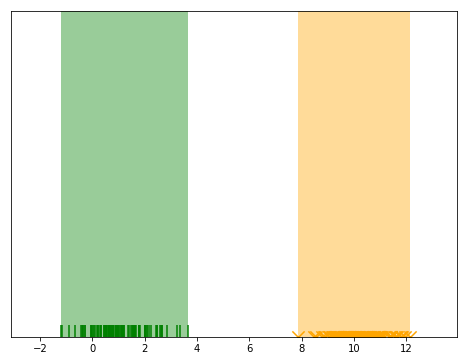

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x[:N], np.zeros(N), c='green', marker=2, s=150)
ax.scatter(x[N:], np.zeros(N), c='orange', marker='x', s=150)
ax.set_ylim([-1e-4, 1e-4])
_ = ax.set_yticks([])
sns.distplot(x[:N], color='green')
sns.distplot(x[N:], color='orange')

<p>In this case, we have a model: $p(\mathbf{x},\mathbf{z}; \Theta)$, where only $\mathbf{x}$ is observed. Our goal is to maximize $L(\Theta)=\prod_{i}p(x^{(i)};\Theta)$. It is common to instead maximize the <strong><em>log likelihood</em></strong>: $\ell(\Theta)=\sum_{i}ln~p(x^{(i)}; \Theta)$. This is also called the <strong><em>incompelte data log likelihood</em></strong> because we do not know the latent variable $\mathbf{z}$ that indicate each data point’s memebrship (to density which a data point belongs).</p> <p>To gain more insights on why this problem is diffcult, we decompose the log likelihood:</p> 

<div>\begin{align} \ell(\Theta) &= \sum_{i}ln~p(x^{(i)}; \Theta) \\ &= \sum_{i} ln \sum_{z^{(i)}} p(x^{(i)}, z^{(i)}; \Theta) \end{align}</div> 

<p>Note that there is summation over $z^{(i)}$ inside logarithm. Even if individual joint probability distributions are in the exponential families, the summation still makes the derivative intractable.</p> <hr /> 

<p>An example of a latent variable model is the Latent Dirichlet Allocation<sup id="fnref-1"><a class="footnote-ref" href="#fn-1">1</a></sup> (LDA) model for uncovering latent topics in documents of text. Once finished deriving the general EM equations, we'll (begin to) apply them to this model.</p>
<h2>Why not maximum likelihood estimation?</h2>
<p>As the adage goes, computing the MLE with respect to this marginal is "hard." I loosely understand why. In any case, Bishop<sup id="fnref-2"><a class="footnote-ref" href="#fn-2">2</a></sup> states:</p>
<blockquote>
<p>A key observation is that the summation over the latent variables appears inside the logarithm. Even if the joint distribution <span class="math">\(p(\mathbf{X, Z}\vert\theta)\)</span> belongs to the exponential family, the marginal distribution <span class="math">\(p(\mathbf{X}\vert\theta)\)</span> typically does not as a result of this summation. The presence of the sum prevents the logarithm from acting directly on the joint distribution, resulting in complicated expressions for the maximum likelihood solution.</p>
</blockquote>
<p><strong>We'll want something else to maximize instead.</strong></p> <hr />

<h3 id="jensen-inequality">Jensen Inequality</h3> <p>Before we talk about how EM algorithm can help us solve the intractability, we need to introduce Jensen inequality. This will be used later to construct a (tight) lower bound of the log likelihood.</p> <p>Definition:</p> 

<blockquote> <p>Let function $f$ be a convex function (e.g., $f’’ \geq 0$). Let $x$ be a random variable. Then we have $f(E[x]) \leq E[f(x)]$.</p> <p>Further, $f$ is <strong><em>strictly convex</em></strong> if $f’’ \gt; 0$. In such case, $f(E[x]) = E[f(x)]$ i.f.f. $x=E[x]$</p> <p>On the other hand, $f$ is concave if $f’’ \leq 0$, and we have $f(E[x]) \geq E[f(x)]$.</p> </blockquote> 

<p>A useful example (that will be applied in EM algorithm) is $f(x) = ln~x$ is <strong><em>strictly concave</em></strong> for $x \gt 0$. Proof:</p> <div>\begin{align} f''(x) = \frac{d~}{dx} f'(x) = \frac{d~\frac{1}{x}}{dx} = -\frac{1}{x^2} \lt 0 \end{align}</div> <p>Therefore, we have $ln~E[x] \geq E[ln~x]$</p> <p>Let’s go with a concrete example by plotting $f(x) = ln~x$</p> 

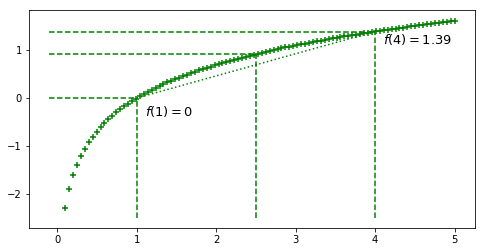

In [8]:
x = np.linspace(.1, 5, 100)
y = np.log(x)
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x, y, color='green', marker='+')
## 1 (p=0.5)
ax.vlines(x=1, ymin=-2.5, ymax=0, linestyle='--', color='green')
ax.hlines(y=0, xmin=-.1, xmax=1, linestyle='--', color='green')
ax.text(x=1.1, y=np.log(.7), s='$f(1)=0$',
        fontdict={'size': 13})
## 4 (p=0.5)
ax.vlines(x=4, ymin=-2.5, ymax=np.log(4), linestyle='--', color='green')
ax.hlines(y=np.log(4), xmin=-.1, xmax=4, linestyle='--', color='green')
ax.text(x=4.1, y=np.log(3.1), 
        s='$f(4)=%.2f$'%(np.log(4)),
        fontdict={'size': 13}
       )
ax.plot([1, 4], np.log([1, 4]), color='green', linestyle='dotted')
# E(x) = (1+4)/2 = 2.5
ax.vlines(x=2.5, ymin=-2.5, ymax=np.log(2.5), linestyle='--', color='green')
ax.hlines(y=np.log(2.5), xmin=-.1, xmax=2.5, linestyle='--', color='green')

<h3 id="em-algorithm-formalization">EM Algorithm Formalization</h3> 

<h4 id="derivation">Derivation</h4> <p>Now we can formarlize the problem, starting from the log likelihood from Section 1:</p> 

<div>\begin{align} \ell(\Theta) & = \sum_i ln~\sum_{z^{(i)}} p(x^{(i)}, z^{(i)}; \Theta) \\ & = \sum_i ln~\sum_{z^{(i)}} q_i(z^{(i)}) \frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} \end{align}</div> <p>where $q_i(z^{(i)})$ is any arbitrary probability distribution for $z^{(i)}$ and thus:$q_i(z^{(i)}) \geq 0; \sum_{z^{(i)}}~q_i(z^{(i)}) = 1$.</p> <p>It is interesting (actually important) to note that the summation inside the logarithm, $\sum_{z^{(i)}} q_i(z^{(i)}) \frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})}$, takes the form of expectation of $\frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})}$, given $x^{(i)}$. Recall that $E[f(x)] = \sum_i p(x^{(i)})f(x^{(i)})$, where $p(x)$ is the probability mass function for $x^{(i)}$. Therefore, we can write the above into:</p> <div>\begin{equation} \ell(\Theta) = \sum_i ln~E_{z^{(i)} \sim q_i(z^{(i)})}\Big[ \frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} \Big] \end{equation}</div> <p>Now, it is not difficult to see that we can apply Jensen Inequality on the term within the summation over $i$:</p> <div> \begin{align} \ell(\Theta) & = \sum_i ln~E_{z^{(i)} \sim q_i(z^{(i)})}\Big[ \frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} \Big] \\ & \geq \sum_i E_{z^{(i)} \sim q_i(z^{(i)})} \Big[ ln~\frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} \Big] \\ & = \sum_i \sum_{z^{(i)}} q_i(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} \end{align} </div> <p>In this way, we successfully construct the lower bound for $\ell(\Theta)$. However, this is not enough. Note that we want to squeeze the lower bound as much as we can to obtain the <strong><em>equality</em></strong>. Based on Section 2, we need</p> 

$$\frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})} = c$$ 

<p>where $c$ is some constant. And this leads to</p> 


$$q_i(z^{(i)}) \propto p(x^{(i)}, z^{(i)}; \Theta)~~ s.t. \sum_{z^{(i)}} q_i(z^{(i)}) = 1$$


<p>From the formula above, we can determine the choice of $q$</p> <div> \begin{align} q_i(z^{(i)}) & = \frac{p(x^{(i)}, z^{(i)}; \Theta)}{\sum_z p(x^{(i)}, z; \Theta)} \\ & = \frac{p(x^{(i)}, z^{(i)}; \Theta)}{p(x^{(i)}; \Theta)} \\ & = p(z^{(i)}\vert x^{(i)}; \Theta) \end{align} </div> <p>The last term is actually the posterior distribution of $z^{(i)}$ (soft membership) given the observation $x^{(i)}$ and the paramter $\Theta$</p> <h4 id="algorithm-operationalization">Algorithm Operationalization</h4> <p>EM is an iterative algorithm that consists of two steps:</p> <ul> <li>E step: Let $q_i(z^{(i)}) = p(z^{(i)}\vert x^{(i)}; \Theta)$. The gives a tight lower bound for $\ell(\Theta)$. This is actually maximizing the expectation shown above.</li> <li>M step: Update parameters to maximize the lower bound $\Theta := argmax_{\Theta} \sum_i \sum_{z^{(i)}} q_i(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta)}{q_i(z^{(i)})}$</li> </ul> 


<h4 id="convergence">Convergence</h4> 

<p>To prove the convergence of EM algorithm, we can prove the fact that $\ell(\Theta^{(t+1)}) \geq \ell(\Theta^{(t)})$ for any $t$, where $\Theta^{(t)}$ is the parameter estimatations at iteration $t$.</p> <p>Recall that we choose $q_i(z^{(i)}) = p(z^{(i)}\vert x^{(i)}; \Theta)$ so that Jensen inequality will become <strong><em>equality</em></strong> such that:</p> <div> $$\ell(\Theta^{(t)})= \sum_i \sum_{z^{(i)}} q_i^{(t)}(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta^{(t)})}{q_i^{(t)}(z^{(i)})}$$ </div> <p>In the M step, we then update our parameter to be $\Theta^{(t+1)}$ that maximizes the R.H.S. of the equation above:</p> <div>\begin{align} \ell(\Theta^{(t+1)}) & = \sum_i \sum_{z^{(i)}} q_i^{(t+1)}(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta^{(t+1)})}{q_i^{(t+1)}(z^{(i)})} \\ & \geq \sum_i \sum_{z^{(i)}} q_i^{(t)}(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta^{(t+1)})}{q_i^{(t)}(z^{(i)})} \\ & \geq \sum_i \sum_{z^{(i)}} q_i^{(t)}(z^{(i)})ln~\frac{p(x^{(i)}, z^{(i)}; \Theta^{(t)})}{q_i^{(t)}(z^{(i)})} \\ & = \ell(\Theta^{(t)}) \end{align}</div> <p>Therefore, EM algorithm will make the log likelihood change monotonically. A common practice to monitor the convergence is to test if the difference of log likelihoods at two success iterations is less than some predefined tolerance parameter.</p> <hr /> 


<h3 id="towards-deeper-understanding-of-em-evidence-lower-bound-elbo">Towards deeper understanding of EM: Evidence Lower Bound (ELBO)</h3> 

<p>We just derived the formulation of EM algorithm in details. However, one thing we did not do is to explicitly write out the decomposition of $\ell(\Theta)$. In fact, we can mathematically write out the log likelihood into the sum of two terms:</p> <ul> <li>$KL(q\vert \vert p) = \sum_{z} q(z) ln~ \frac{q(z)}{p(z \vert \mathbf{x}; \Theta)}$</li> <li>$\mathcal{L}(\mathbf{x}; \Theta) = \sum_{z} q(z) ln~ \frac{p(\mathbf{x}, z; \Theta)}{q(z)}$</li> </ul> 


<h4 id="derivation-1">Derivation</h4> <div>\begin{align} ln~p(\mathbf{x}; \Theta) & = \sum_{z} q(z) ln p(\mathbf{x}; \Theta) \\ & [\text{Recall that } \sum_z q(z) = 1] \\ & = \sum_{z} q(z) ln~ \frac{p(\mathbf{x}, z; \Theta)}{p(z \vert \mathbf{x}; \Theta)} \\ & = \sum_{z} q(z) ln~ \frac{p(\mathbf{x}, z; \Theta)~q(z)}{p(z \vert \mathbf{x}; \Theta) ~q(z)} \\ & = \sum_{z} q(z) ln~ \frac{p(\mathbf{x}, z; \Theta)}{q(z)} + \sum_{z} q(z) ln~ \frac{q(z)}{p(z \vert \mathbf{x}; \Theta)}\\ & = \mathcal{L}(\mathbf{x}; \Theta) + KL(q\vert \vert p) \end{align}</div> <h4 id="elbo">ELBO</h4> <p>Here, we define evidence lower bound to be $ELBO = \mathcal{L}(\mathbf{x}; \Theta)$, because KL-divergence is non-negative. Specifically, the equality only holds when $q(z) = p(z \vert \mathbf{x}; \Theta)$. Therefore, $ELBO$ can be seen as a <strong><em>tight</em></strong> lower bound of the evidence (incomplete data likelihood):</p> 


$$ln~p(\mathbf{x}; \Theta) \geq ELBO$$


<p>Such result is actually consistent with the previous derivation where we directly apply Jensen’s inequality.</p> <hr /> <h3 id="applying-em-on-gaussian-mixtures">Applying EM on Gaussian Mixtures</h3> <p>In this section, we will use an example of Gaussian Mixture to demonstrate the application of EM algorithm.</p> <p>Suppose we have some data $\mathbf{x}={x^{(1)}, …, x^{(m)}}$, which some from $K$ different Gaussian distributions ($K$ mixtures). We will use the following notations:</p> <ul> <li>$\mu_k$: the mean of the $k^{th}$ Gaussian component</li> <li>$\Sigma_k$: the covariance matrix of the $k^{th}$ Gaussian component</li> <li>$\phi_k$: the multinomial parameter of a specific datapoint belonging to the $k^{th}$ componenet.</li> <li>$z^{(i)}$: the latent variable (multinomial) for each $x^{(i)}$</li> </ul> <p>We also assume that the dimension of each $x^{(i)}$ is $n$.</p> <p>The goal is: $max_{\mu, \Sigma, \phi}~ln~p(\mathbf{x};\mu, \Sigma, \phi)$. Therefore this follows exactly the EM framework.</p> 


<h4 id="e-step">E step</h4> <p>We set $w_j^{(i)} = q_i(z^{(i)}=j) = p(z^{(i)}=j \vert x^{(i)}; \mu, \Sigma, \phi)$.</p> 


<h4 id="m-step">M step</h4> <p>We will write down the lower bound and get derivatives for each of the three parameters.</p> 


<div>\begin{align} \sum_{i}^{m} \sum_{j}^{K} & q_i(z^{(i)}=j) ln~\frac{p(x^{(i)}, z^{(i)}=j; \mu, \Sigma, \phi)}{q_i(z^{(i)}=j)} \\ &= \sum_{i}^{m} \sum_{j}^{K} q_i(z^{(i)}=j) ln~\frac{p(x^{(i)}\vert z^{(i)}=j; \mu, \Sigma) p(z^{(i)}=j; \phi)}{q_i(z^{(i)}=j)} \end{align}</div> 

<p>Note that:</p> <ul> <li>$x^{(i)} \vert z^{(i)}=j; \mu, \Sigma \sim \mathcal{N}(\mu_j, \Sigma_j)$</li> <li>$z^{(i)}=j; \phi \sim Multi(\phi)$</li> </ul> 


<p>We can then leverage these probability distributions and continue</p> 

<div>\begin{align} ll := \sum_{i}^{m} \sum_{j}^{K} w_j^{(i)} ln~\frac{\frac{1}{\sqrt{(2\pi)^{n}\vert\Sigma_j\vert}}~exp\Big(-\frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j)\Big)~\phi_j}{w_j^{(i)}} \end{align}</div> 


<p>Now, we need to maximize this lower bound for each of the three parameters. Many of the derivative on vector/matrix are based on <a href="http://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf">Matrix Cookbook</a></p> 


<h5 id="derivative-of-mu_j">Derivative of $\mu_j$</h5> 

<div>\begin{align} \nabla_{\mu_j} ll & = \nabla_{\mu_j} \sum_{i}^{m} w_j^{(i)} ln~\frac{\frac{1}{\sqrt{(2\pi)^{n}\vert\Sigma_j\vert}}~exp\Big(-\frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j)\Big)~\phi_j}{w_j^{(i)}} \\ & = \nabla_{\mu_j} \sum_{i}^{m} w_j^{(i)} \Big[ ln~\frac{\frac{1}{\sqrt{(2\pi)^{n}\vert\Sigma_j\vert}}~\phi_j}{w_j^{(i)}} + ln~exp\Big(-\frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j)\Big) \Big] \\ & = \nabla_{\mu_j} \sum_{i}^{m} w_j^{(i)} \Big[ \frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) \Big] \\ & = -\frac{1}{2} \sum_{i}^{m} w_j^{(i)} \nabla_{\mu_j}\Big[ (x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) \Big] \\ & \big[ \text{For } f(x) = x^T A x \text{: } \nabla_{x} f(x) = (A+A^T)x\big] \\ & = \frac{1}{2} \sum_{i}^{m} w_j^{(i)} \nabla_{(x^{i} - \mu_j)}\Big[ (x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) \Big] \\ & = \frac{1}{2} \sum_{i}^{m} w_j^{(i)} \Big[ (\Sigma_j^{-1} + (\Sigma_j^{-1})^T) (x^{(i)} - \mu_j) \Big] \\ & \big[ \text{Note that } \Sigma_j \text{ is symmetric so we have } (\Sigma_j^{-1})^T = (\Sigma_j^{T})^{-1} =\Sigma_j^{-1} \big] \\ & = \sum_{i}^{m} w_j^{(i)} \Big[ \Sigma_j^{-1} (x^{(i)} - \mu_j) \Big] \\ \end{align}</div> 


<p>Set the last term zero, we have</p> 


<div>\begin{align} \nabla_{\mu_j} ll & = 0 \\ \sum_{i}^{m} w_j^{(i)} \Big[ \Sigma_j^{-1} (x^{(i)} - \mu_j) \Big] & = 0 \\ \sum_{i}^{m} w_j^{(i)}(x^{(i)} - \mu_j) & = 0 \\ \sum_{i}^{m} w_j^{(i)} x^{(i)} & = \sum_{i}^{m} w_j^{(i)} \mu_j \\ \mu_j & = \frac{\sum_{i}^{m} w_j^{(i)} x^{(i)}}{\sum_{i}^{m} w_j^{(i)}} \end{align}</div> 


<h5 id="derivative-of-sigma_j">Derivative of $\Sigma_j$</h5> 

<div>\begin{align} \nabla_{\Sigma_j} ll & = \nabla_{\Sigma_j} \sum_{i}^{m} w_j^{(i)} ln~\frac{\frac{1}{\sqrt{(2\pi)^{n}\vert\Sigma_j\vert}}~exp\Big(-\frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j)\Big)~\phi_j}{w_j^{(i)}} \\ & = \sum_{i}^{m} w_j^{(i)} \nabla_{\Sigma_j} \Big[ ln~\frac{1}{\sqrt{\vert\Sigma_j\vert}} - \frac{1}{2}(x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) \Big] \\ & = -\frac{1}{2} \sum_{i}^{m} w_j^{(i)} \Big[ \frac{\partial~ln~\vert\Sigma_j\vert}{\partial \Sigma_j} + \frac{\partial}{\partial \Sigma_j} (x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) \Big] \\ \end{align}</div> 

<p>First, we consider the derivative of the first term in the square bracket:</p> 


<div>\begin{align} \frac{\partial ln~\vert\Sigma_j\vert}{\partial \Sigma_j} & = \frac{1}{\vert\Sigma_j\vert} \frac{\partial \vert\Sigma_j\vert}{\partial \Sigma_j} \\ & = \frac{1}{\vert\Sigma_j\vert}\vert\Sigma_j\vert (\Sigma_j^{-1})^T \\ & = \Sigma_j^{-1} \end{align}</div> 

<p>Then, we do the second term</p> 


<div>\begin{align} \frac{\partial}{\partial \Sigma_j} (x^{(i)}-\mu_j)^{T}\Sigma_j^{-1}(x^{(i)}-\mu_j) & = -\Sigma_j^{-1}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T} \Sigma_j^{-1} \\ \end{align}</div> 


<p>Combined these results back and set it to zero, we have:</p> 


<div>\begin{align} \nabla_{\Sigma_j} ll & = -\frac{1}{2} \sum_i^{m} w_j^{(i)} \Big[ \Sigma_j^{-1} - \Sigma_j^{-1}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T} \Sigma_j^{-1} \Big]\\ & = -\frac{1}{2} \sum_i^{m} w_j^{(i)} \Big[ I - \Sigma_j^{-1}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T} \Big] \Sigma_j^{-1} \stackrel{set}{=} 0 \\ \end{align}</div> 

<p>Rearrange the equation and we have:</p> 

<div>\begin{align} \sum_i^{m} w_j^{(i)} \Big[ \Sigma_j - (x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T} \Big] &= 0 \\ \sum_i^{m} w_j^{(i)} \Sigma_j &= \sum_i^{m} w_j^{(i)} (x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T} \\ \Sigma_j & = \frac{\sum_i^{m} w_j^{(i)} (x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^{T}}{\sum_i^{m} w_j^{(i)}} \end{align}</div> 


<h5 id="derivative-of-phi_j">Derivative of $\phi_j$</h5> 

<p>This is relatively simpler but we need to apply Lagrange multipliers because $\sum_j \phi_j = 1$.</p> 

<div>\begin{align} ll & = \sum_{i}^{m} \sum_{l}^{k} w_l^{(i)} ln~\frac{\frac{1}{\sqrt{(2\pi)^{n}\vert\Sigma_l\vert}}~exp\Big(-\frac{1}{2}(x^{(i)}-\mu_l)^{T}\Sigma_l^{-1}(x^{(i)}-\mu_l)\Big)~\phi_l}{w_l^{(i)}} \\ & = \sum_{i}^{m} \sum_{l}^{k} w_l^{(i)} ln~\phi_l \\ \end{align}</div> 


<p>We need to construct Lagrangian, with $\lambda$ as the Lagrange multiplier:</p> 

$$\mathcal{L}(\phi) = ll + \lambda (\sum_l^{k} \phi_l - 1)$$


<p>We will take derivative on $\mathcal{L}$ and set it to zero:</p> 

<div>\begin{align} \frac{\partial \mathcal{L}(\phi)}{\partial \phi_j} & = \frac{\partial}{\partial \phi_j} \Big[ ll + \lambda (\sum_l^{k} \phi_l - 1) \Big] \\ & = \sum_i w_j^{(i)} \frac{1}{\phi_j} + \lambda \stackrel{set}{=} 0\\ \end{align}</div> 

<p>Rearrange and we will have $\phi_j = -\frac{\sum_i w_j^{(i)}}{\lambda}$. Recall that $\sum_j \phi_j = 1$, we have:</p> 


<div>\begin{align} \sum_j \phi_j & = \sum_j -\frac{\sum_i w_j^{(i)}}{\lambda} = 1\\ \lambda & = -\sum_j \sum_i w_j^{(i)} \\ & = -\sum_j \sum_i p(z^{(i)}=j\vert x^{(i)}) \\ & = -\sum_i 1 = -m \end{align}</div> 


<p>Finally, we have:</p> 

$$\phi_j = \frac{\sum_i w_j^{(i)}}{m}$$ <hr /> 

<h3 id="real-example">Real example</h3> 

In [9]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
        #print(self.sigma_arr)

In [10]:
X = np.random.multivariate_normal([0, 3], [[0.5, 0], [0, 0.8]], 20)
X = np.vstack((X, np.random.multivariate_normal([20, 10], np.identity(2), 50)))
X.shape

(70, 2)

In [11]:
gmm = GMM(X)
gmm.fit()

Iteration 1: log-likelihood is -401.757530
Iteration 2: log-likelihood is -313.179330
Iteration 3: log-likelihood is -273.071169
Iteration 4: log-likelihood is -216.392571
Iteration 5: log-likelihood is -215.602209
Iteration 6: log-likelihood is -215.602209
Terminate at 6-th iteration:log-likelihood is -215.602209


In [12]:
gmm.mean_arr

matrix([[ 0.09072331,  2.9877357 ],
        [20.06700999, 10.07334452]])

In [13]:
gmm.sigma_arr

array([[[ 0.5926634 , -0.13837292],
        [-0.13837292,  0.2280045 ]],

       [[ 0.86967146, -0.24890064],
        [-0.24890064,  1.07548725]]])

In [14]:
gmm.phi

array([0.28571429, 0.71428571])